In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Lasso, Ridge

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [9]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Load the data

In [10]:
df = pd.read_excel("./data/species.xlsx")

X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
print(y_train.describe())

count    21.000000
mean     12.500000
std       7.293833
min       1.500000
25%       5.000000
50%      12.000000
75%      20.000000
max      25.000000
Name: price, dtype: float64


## Modeling steps (n ≈ 21 training samples, p ≈ 20 predictors)

To account for the small sample size and high dimensionality, we adopted the following strategy:

- **Leave-One-Out Cross-Validation (LOOCV)** for all model tuning and comparison  
- **Baseline model:** DummyRegressor (mean predictor) to establish a performance benchmark  
- **Regularized linear models:** Ridge and Lasso (appropriate for small-n, high-p settings)  
- **Support Vector Regression (SVR):** applied with feature scaling via StandardScaler  
- **Random Forest:** trained without scaling (tree-based models are scale-invariant)  
- **Dimensionality reduction:** SVR combined with PCA to mitigate high dimensionality and improve stability  
- **Fair model comparison:** one-pass evaluation using `cross_validate` with a consistent metric (RMSE)


## CV + scoring (single source of truth)

In [12]:
# ------------------------------------------------------------
# Cross-validation and scoring setup (small-data setting)
# ------------------------------------------------------------

# Use Leave-One-Out CV because the training set is very small (n ≈ 21).
# Each observation is used once as a test point.
cv = LeaveOneOut()

# Define scoring metric.
# sklearn returns *negative* RMSE, so we will later flip the sign.
scoring = {
    "rmse": "neg_root_mean_squared_error"
}


def compare_models(models, X, y, cv):
    rows = []
    for name, model in models.items():
        out = cross_validate(
            model, X, y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )

        rmse = -out["test_rmse"]

        rows.append([
            name,
            rmse.mean(),
            rmse.std(ddof=0)
        ])

    return pd.DataFrame(rows, columns=[
        "model", "CV_RMSE_mean", "CV_RMSE_std"
    ]).sort_values("CV_RMSE_mean")


In [13]:
# ------------------------------------------------------------
# Helper function: summarize RMSE from cross_validate output
# ------------------------------------------------------------

def rmse_mean_std(cv_out):
    """
    Extract and summarize RMSE from sklearn's cross_validate output.

    Parameters:
    - cv_out: dict returned by cross_validate, containing 'test_rmse'

    Returns:
    - dict with mean and standard deviation of RMSE across folds
    """

    # Flip sign to get positive RMSE values
    rmse = -cv_out["test_rmse"]

    return {
        "CV_RMSE_mean": rmse.mean(),        # average LOOCV RMSE
        "CV_RMSE_std": rmse.std(ddof=0),    # standard deviation across folds
    }

In [14]:
# ------------------------------------------------------------
# Model comparison function
# ------------------------------------------------------------
def compare_models(models, X, y, cv):
    """
    Compare multiple models using LOOCV and RMSE.

    Parameters:
    - models: dict mapping model names to sklearn estimators/pipelines
    - X: feature matrix (DataFrame)
    - y: target vector
    - cv: cross-validation strategy (LeaveOneOut)

    Returns:
    - DataFrame sorted by increasing CV_RMSE_mean (lower is better)
    """

    rows = []

    for name, model in models.items():

        # Perform cross-validation in a single pass
        out = cross_validate(
            model, X, y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )

        # Convert negative RMSE back to positive
        rmse = -out["test_rmse"]

        # Store model name + mean and std of RMSE
        rows.append([
            name,
            rmse.mean(),
            rmse.std(ddof=0)
        ])

    # Convert results to a clean table and sort by best (lowest) RMSE
    return (
        pd.DataFrame(
            rows,
            columns=["model", "CV_RMSE_mean", "CV_RMSE_std"]
        )
        .sort_values("CV_RMSE_mean")
    )

## Preprocessor (scale all numeric)

Many machine learning models (especially SVR, Ridge, Lasso, and PCA) are sensitive to the scale of input
features. To ensure all predictors are on a comparable scale, we standardize every numeric variable to have
mean 0 and standard deviation 1 using `StandardScaler`.

This preprocessing step is applied only to:
- Ridge  
- Lasso  
- SVR  
- SVR + PCA pipelines  

Tree-based models (e.g., Random Forest) do **not** use this step because they are scale-invariant.

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), X_train.columns)   # scale all numeric features
    ],
    remainder="drop"
)

## Baseline model (mean predictor)

As a minimal reference, we fit a DummyRegressor that always predicts the mean of the training target.
This baseline does not use any features and represents the performance we would obtain **without learning
from the data**.

We evaluate this baseline using Leave-One-Out Cross-Validation (LOOCV) and report:
- **CV_RMSE_mean:** average prediction error across all LOOCV folds  
- **CV_RMSE_std:** variability of the error across folds


In [16]:
baseline = DummyRegressor(strategy="mean")
baseline_out = cross_validate(baseline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
baseline_stats = rmse_mean_std(baseline_out)
print("\nBaseline (Dummy mean) LOOCV:")
print(baseline_stats)


Baseline (Dummy mean) LOOCV:
{'CV_RMSE_mean': 6.4, 'CV_RMSE_std': 3.8600518131237562}


## Ridge & Lasso (regularized linear models)

With a very small training set (n ≈ 21) and relatively many predictors (p ≈ 20), standard linear regression
would likely overfit. To mitigate this, we use **regularized linear models**:

- **Ridge Regression (L2 regularization):** shrinks all coefficients toward zero, reducing variance while
  keeping all features in the model. This is often a strong baseline in small-n, high-p settings.
- **Lasso Regression (L1 regularization):** can drive some coefficients exactly to zero, performing implicit
  feature selection.

Both models are trained within a pipeline that standardizes all numeric features using `StandardScaler`.
We tune the regularization strength (`alpha`) via Leave-One-Out Cross-Validation (LOOCV), using RMSE as the
optimization metric.

### Ridge (strong small-data baseline)

In [17]:
ridge_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge())
])

ridge_grid = {
    "model__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]
}

ridge_cv = GridSearchCV(
    ridge_pipe,
    ridge_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)
ridge_cv.fit(X_train, y_train)
print("\nBest Ridge params:", ridge_cv.best_params_)
print("Best Ridge score (neg RMSE):", ridge_cv.best_score_)


Best Ridge params: {'model__alpha': 100.0}
Best Ridge score (neg RMSE): -6.258070443408063


### Lasso (feature selection; can help in high-p, small-n)

In [18]:
lasso_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", Lasso(max_iter=200000, tol=1e-3, random_state=42))
])

lasso_grid = {"model__alpha": [0.01, 0.05, 0.1, 0.5, 1.0]}

lasso_cv = GridSearchCV(
    lasso_pipe,
    lasso_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)
lasso_cv.fit(X_train, y_train)
print("\nBest Lasso params:", lasso_cv.best_params_)
print("Best Lasso score (neg RMSE):", lasso_cv.best_score_)


Best Lasso params: {'model__alpha': 1.0}
Best Lasso score (neg RMSE): -6.613228131939536


## SVR (RBF) with scaling

We train an RBF-kernel SVR within a standardized pipeline and tune `C`, `gamma`, and `epsilon` using
Leave-One-Out Cross-Validation (LOOCV) and RMSE. 

The grid is kept small to control computation time.

In [19]:
svr_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", SVR(kernel="rbf"))
])

svr_grid = {
    "model__C": [1, 5, 10],
    "model__gamma": [0.05, 0.1],
    "model__epsilon": [0.05, 0.1]
}

svr_cv = GridSearchCV(
    svr_pipe,
    svr_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)
svr_cv.fit(X_train, y_train)
print("\nBest SVR params:", svr_cv.best_params_)
print("Best SVR score (neg RMSE):", svr_cv.best_score_)


Best SVR params: {'model__C': 10, 'model__epsilon': 0.05, 'model__gamma': 0.1}
Best SVR score (neg RMSE): -5.2583194146766585


### SVR + PCA (often stabilizes small-n high-p)

In [20]:
svr_pca_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("pca", PCA()),
    ("model", SVR(kernel="rbf"))
])


# We jointly tune:
# - pca__n_components: how many principal components to keep
# - model__C: regularization strength (larger = more flexible)
# - model__gamma: controls smoothness of RBF function
# - model__epsilon: width of insensitive tube
svr_pca_grid = {
    "pca__n_components": [3, 5, 8, 10],
    "model__C": [1, 5, 10],
    "model__gamma": [0.05, 0.1],
    "model__epsilon": [0.05, 0.1]
}

svr_pca_cv = GridSearchCV(
    svr_pca_pipe,
    svr_pca_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)
svr_pca_cv.fit(X_train, y_train)
print("\nBest SVR+PCA params:", svr_pca_cv.best_params_)
print("Best SVR+PCA score (neg RMSE):", svr_pca_cv.best_score_)


Best SVR+PCA params: {'model__C': 10, 'model__epsilon': 0.05, 'model__gamma': 0.1, 'pca__n_components': 5}
Best SVR+PCA score (neg RMSE): -4.866024373428904


#### PCA explained variance (how much variance components capture)

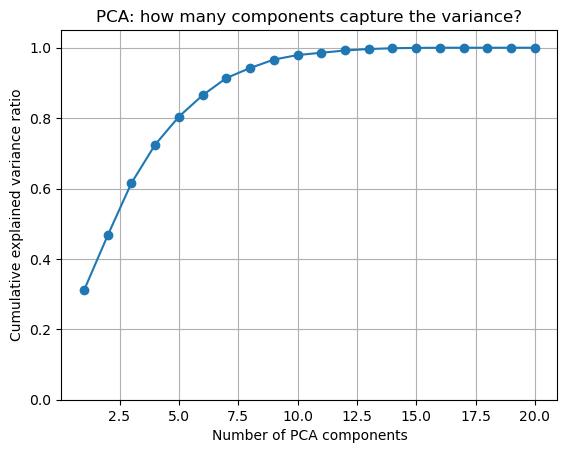

In [21]:
X_train_scaled = preprocessor.fit_transform(X_train)
pca_full = PCA().fit(X_train_scaled)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n = np.arange(1, len(cum_var) + 1)

plt.figure()
plt.plot(n, cum_var, marker="o")
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("PCA: how many components capture the variance?")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

### Effect of n_components on LOOCV RMSE (from GridSearch)

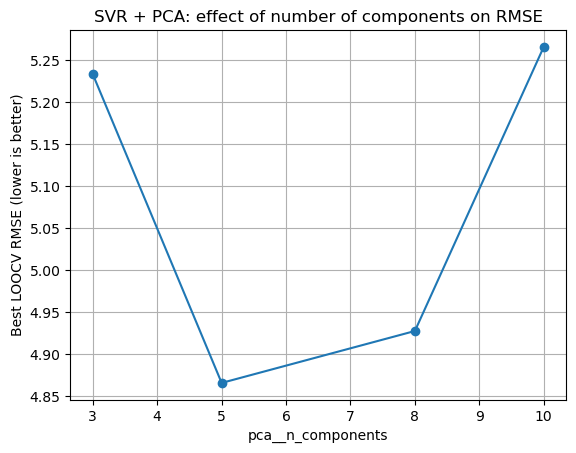

In [22]:
res = pd.DataFrame(svr_pca_cv.cv_results_)

# Convert negative RMSE -> positive RMSE
res["rmse_pos"] = -res["mean_test_rmse"]

# For each n_components, take the best (lowest) RMSE across other params
best_by_k = (
    res.groupby("param_pca__n_components")["rmse_pos"]
       .min()
       .reset_index()
       .sort_values("param_pca__n_components")
)

plt.figure()
plt.plot(best_by_k["param_pca__n_components"], best_by_k["rmse_pos"], marker="o")
plt.xlabel("pca__n_components")
plt.ylabel("Best LOOCV RMSE (lower is better)")
plt.title("SVR + PCA: effect of number of components on RMSE")
plt.grid(True)
plt.show()

The plot indicates that retaining 5 principal components yields the best predictive performance, while using fewer (3) leads to underfitting and using more (8–10) leads to overfitting

## Random Forest - NO scaling

In [23]:
rf_pipe = Pipeline([
    ("model", RandomForestRegressor(random_state=42))
])

# Keep the grid small because LOOCV is expensive and n is very small.
# - n_estimators: number of trees (more trees = lower variance but slower)
# - max_depth: depth constraint (limits complexity / overfitting)
# - min_samples_leaf: minimum samples per leaf (regularizes the tree)
rf_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10],
    "model__min_samples_leaf": [2, 5]
}

rf_cv = GridSearchCV(
    rf_pipe,
    rf_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)
rf_cv.fit(X_train, y_train)
print("\nBest RF params:", rf_cv.best_params_)
print("Best RF score (neg RMSE):", rf_cv.best_score_)


Best RF params: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__n_estimators': 200}
Best RF score (neg RMSE): -5.261848356009072


### Feature importance from the best RF model

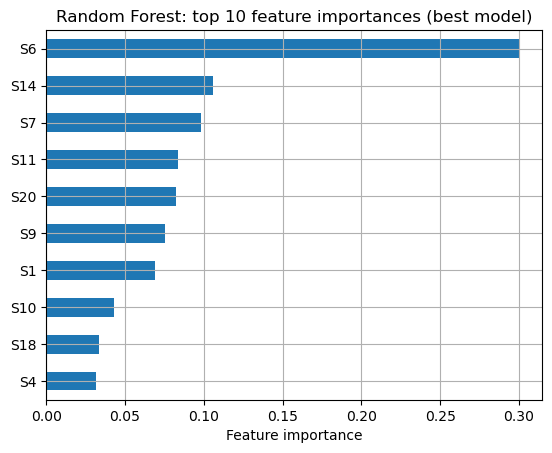

In [24]:
# best_estimator_ is already refit on the full training set
best_rf = rf_cv.best_estimator_.named_steps["model"]

importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
top_imp = importances.sort_values(ascending=False).head(10)

plt.figure()
top_imp.sort_values().plot(kind="barh")
plt.xlabel("Feature importance")
plt.title("Random Forest: top 10 feature importances (best model)")
plt.grid(True)
plt.show()

## Final comparison

In [25]:
models_best = {
    "Dummy_mean": baseline,
    "Ridge_best": ridge_cv.best_estimator_,
    "Lasso_best": lasso_cv.best_estimator_,
    "SVR_best": svr_cv.best_estimator_,
    "SVR_PCA_best": svr_pca_cv.best_estimator_,
    "RF_best": rf_cv.best_estimator_
}

summary_df = compare_models(models_best, X_train, y_train, cv)
print("\nLOOCV Summary (sorted by RMSE):")
display(summary_df)


LOOCV Summary (sorted by RMSE):


,model,CV_RMSE_mean,CV_RMSE_std
4,SVR_PCA_best,4.866024,4.952459
3,SVR_best,5.258319,4.847911
5,RF_best,5.261848,4.632864
1,Ridge_best,6.258070,3.993229
0,Dummy_mean,6.400000,3.860052
2,Lasso_best,6.613228,4.341335


Across all models evaluated with LOOCV, SVR with PCA achieved the lowest mean RMSE (4.87), indicating that combining nonlinear modeling with dimensionality reduction yields the most stable and accurate predictions in this small-n, high-p setting. Plain SVR and Random Forest performed comparably but worse than SVR+PCA, while Ridge offered only marginal gains over the mean baseline and Lasso underperformed, suggesting that purely linear models are ill-suited for this problem

## 1) Baseline evaluation (mean predictor)

Before assessing any machine learning model, we first evaluate a simple baseline that always predicts the
mean of the training target. This serves as a reference point: any useful model should clearly outperform
this baseline.

We report:
- **RMSE (primary metric):** average prediction error in the original price units  
- **R²:** proportion of variance explained (mainly for reference)

In [26]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print("Baseline Test RMSE:", root_mean_squared_error(y_test, y_dummy))
print("Baseline Test R2:", r2_score(y_test, y_dummy))

Baseline Test RMSE: 7.834219807996199
Baseline Test R2: -0.002836718484057643


## 2) Evaluate the selected best model on the held-out test set

Based on Leave-One-Out Cross-Validation (LOOCV), the best-performing model was **SVR with PCA
dimensionality reduction (SVR_PCA_best)**. 

In this cell, we:
1. Refit this model on the full training set  
2. Generate predictions for the held-out test set (~6 observations)  
3. Report Test RMSE and Test R²  

**Important note:** With such a small test set, R² can be unstable, so RMSE should be considered the more
reliable metric.


In [27]:
from sklearn.metrics import root_mean_squared_error

best_name = summary_df.iloc[0]["model"]   # should be "SVR_PCA_best"
best_model = models_best[best_name]

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"\nSelected model: {best_name}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2:   {test_r2:.4f}")



Selected model: SVR_PCA_best
Test RMSE: 4.8162
Test R2:   0.6210


## 3) Interpretation of results

- The SVR + PCA model substantially outperforms the mean baseline (lower RMSE, higher R²).  
- This suggests the predictor variables contain meaningful information about species price.  
- However, results should be interpreted cautiously because:
  - the total dataset is very small (27 samples), and  
  - the test set contains only ~6 observations.


## Ensemble

In [28]:
estimators = [
    ("svr_pca", svr_pca_cv.best_estimator_),
    ("svr", svr_cv.best_estimator_),
    ("rf", rf_cv.best_estimator_),
    ("ridge", ridge_cv.best_estimator_)
]

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Meta-learner (keep it simple/regularized for small n)
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
    cv=inner_cv,
    n_jobs=-1,
    passthrough=False
)

stack_grid = {
    "final_estimator__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]
}

stack_cv = GridSearchCV(
    stack,
    stack_grid,
    cv=cv,              # outer LOOCV for fair comparison   
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)
stack_cv.fit(X_train, y_train)
best_stack = stack_cv.best_estimator_


In [29]:
from sklearn.ensemble import VotingRegressor

vote = VotingRegressor(
    estimators=[
        ("svr_pca", svr_pca_cv.best_estimator_),
        ("rf", rf_cv.best_estimator_),
        ("svr", svr_cv.best_estimator_),
    ],
    weights=[2, 1, 1]   # emphasize SVR+PCA
)


In [30]:
stack_lasso = StackingRegressor(
    estimators=[
        ("svr_pca", svr_pca_cv.best_estimator_),
        ("rf", rf_cv.best_estimator_),
        ("svr", svr_cv.best_estimator_),
    ],
    final_estimator=Lasso(max_iter=50000),
    cv=inner_cv,
    n_jobs=-1,
    passthrough=False
)

stack_grid = {"final_estimator__alpha": [0.001, 0.01, 0.1, 1.0]}

stack_lasso_cv = GridSearchCV(
    stack_lasso,
    stack_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)

stack_lasso_cv.fit(X_train, y_train)
best_stack_lasso = stack_lasso_cv.best_estimator_

In [31]:
models_best = {
    "Dummy_mean": baseline,
    "SVR_PCA_best": svr_pca_cv.best_estimator_,
    "Voting_Ensemble": vote,
    "Stacking_Ensemble": best_stack,
    "Stacking_Ensemble(Lasso)": best_stack_lasso
}

summary_df = compare_models(models_best, X_train, y_train, cv)
display(summary_df)

,model,CV_RMSE_mean,CV_RMSE_std
1,SVR_PCA_best,4.866024,4.952459
2,Voting_Ensemble,4.981731,4.622400
0,Dummy_mean,6.400000,3.860052
3,Stacking_Ensemble,6.420807,5.256119
4,Stacking_Ensemble(Lasso),7.566449,5.058538


We evaluated stacking and voting ensembles on top of our best base models. However, due to the very small sample size (n≈21) and the strong performance of SVR+PCA, ensemble methods did not improve predictive accuracy. In fact, stacking performed worse, likely due to high variance and instability in the meta-learning stage under LOOCV. Therefore, we select SVR+PCA as the final model.

## Visualization

In [32]:
best_model = svr_pca_cv.best_estimator_

# Fit on training set, evaluate on test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best model:", "SVR_PCA_best")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2:   {r2:.4f}")

Best model: SVR_PCA_best
Test RMSE: 4.8162
Test R2:   0.6210


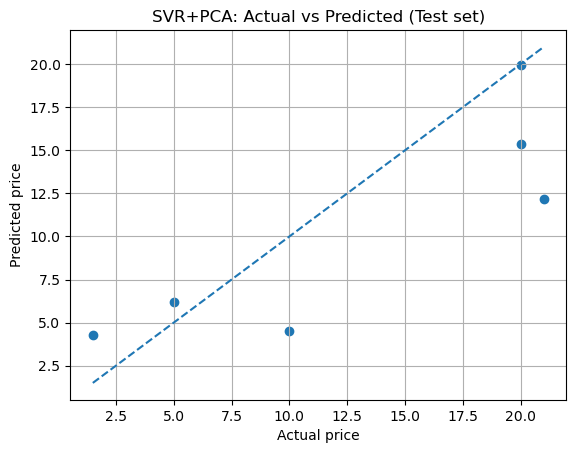

In [33]:
y_test_arr = np.array(y_test)
y_pred_arr = np.array(y_pred)

plt.figure()
plt.scatter(y_test_arr, y_pred_arr)

# y = x reference line
min_v = min(y_test_arr.min(), y_pred_arr.min())
max_v = max(y_test_arr.max(), y_pred_arr.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")

plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("SVR+PCA: Actual vs Predicted (Test set)")
plt.grid(True)
plt.show()


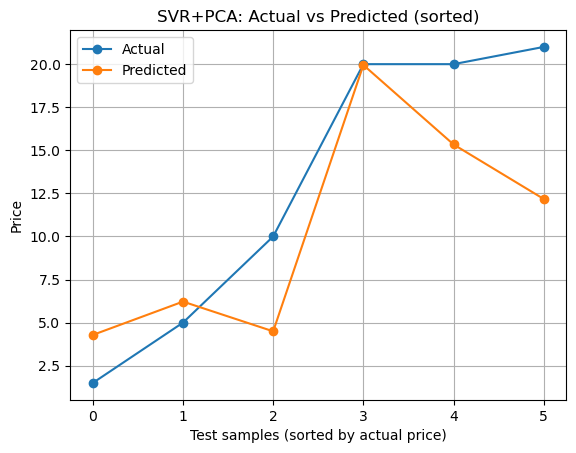

In [34]:
order = np.argsort(y_test_arr)

plt.figure()
plt.plot(y_test_arr[order], marker="o", label="Actual")
plt.plot(y_pred_arr[order], marker="o", label="Predicted")

plt.xlabel("Test samples (sorted by actual price)")
plt.ylabel("Price")
plt.title("SVR+PCA: Actual vs Predicted (sorted)")
plt.grid(True)
plt.legend()
plt.show()


In [35]:
import joblib

# suppose best_model is your trained sklearn model or Pipeline
joblib.dump(best_model, "model.joblib")

['model.joblib']

In [36]:
import numpy as np
print("y mean:", np.mean(y))
print("y std:", np.std(y))
print("min/max:", np.min(y), np.max(y))

y mean: 12.592592592592593
y std: 7.282700248403287
min/max: 1.5 25.0


In [39]:
# ------------------------------------------------------------
# 1. Grid Search with Cross-Validation
# ------------------------------------------------------------
svr_poly_pca_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("pca", PCA(n_components=0.95)),  # Keep 95% variance
    ("model", SVR(kernel="rbf"))
])
# Hyperparameter grid
svr_poly_pca_grid = {
    "poly__degree": [2, 3],  # Try degree 2 and 3 polynomials
    "model__C": [1, 5, 10, 50],
    "model__gamma": ['scale', 0.01, 0.05, 0.1],
    "model__epsilon": [0.01, 0.05, 0.1]
}
svr_poly_pca_cv = GridSearchCV(
    svr_poly_pca_pipe,
    svr_poly_pca_grid,
    cv=cv,  # Your LeaveOneOut CV
    scoring=scoring,
    refit="rmse",
    n_jobs=-1,
    verbose=1
)
print("Training SVR+Poly+PCA model...")
svr_poly_pca_cv.fit(X_train, y_train)
print("\n" + "="*60)
print("SVR + Polynomial Features + PCA Results")
print("="*60)
print(f"\nBest parameters: {svr_poly_pca_cv.best_params_}")
print(f"Best CV score (neg RMSE): {svr_poly_pca_cv.best_score_:.6f}")
print(f"Best CV RMSE: {-svr_poly_pca_cv.best_score_:.6f}")

Training SVR+Poly+PCA model...
Fitting 21 folds for each of 96 candidates, totalling 2016 fits

SVR + Polynomial Features + PCA Results

Best parameters: {'model__C': 10, 'model__epsilon': 0.01, 'model__gamma': 0.1, 'poly__degree': 2}
Best CV score (neg RMSE): -5.219257
Best CV RMSE: 5.219257


In [40]:
# ------------------------------------------------------------
# 2. Detailed Pipeline Inspection
# ------------------------------------------------------------
best_model = svr_poly_pca_cv.best_estimator_
# Check polynomial expansion
poly_step = best_model.named_steps['poly']
print(f"\n--- Polynomial Features ---")
print(f"Degree: {poly_step.degree}")
print(f"Original features: {X_train.shape[1]}")
print(f"After polynomial expansion: {poly_step.n_output_features_}")
# Check PCA compression
pca_step = best_model.named_steps['pca']
print(f"\n--- PCA Dimension Reduction ---")
print(f"Input features (after poly): {poly_step.n_output_features_}")
print(f"Components kept: {pca_step.n_components_}")
print(f"Explained variance ratio per component:")
for i, var in enumerate(pca_step.explained_variance_ratio_[:10], 1):
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%)")
print(f"Total variance explained: {pca_step.explained_variance_ratio_.sum():.4f} ({pca_step.explained_variance_ratio_.sum()*100:.2f}%)")
# SVR parameters
svr_step = best_model.named_steps['model']
print(f"\n--- SVR Configuration ---")
print(f"C: {svr_step.C}")
print(f"gamma: {svr_step.gamma}")
print(f"epsilon: {svr_step.epsilon}")
print(f"Support vectors: {len(svr_step.support_)}")


--- Polynomial Features ---
Degree: 2
Original features: 20
After polynomial expansion: 230

--- PCA Dimension Reduction ---
Input features (after poly): 230
Components kept: 13
Explained variance ratio per component:
  PC1: 0.2043 (20.43%)
  PC2: 0.1445 (14.45%)
  PC3: 0.1285 (12.85%)
  PC4: 0.0996 (9.96%)
  PC5: 0.0907 (9.07%)
  PC6: 0.0639 (6.39%)
  PC7: 0.0509 (5.09%)
  PC8: 0.0417 (4.17%)
  PC9: 0.0332 (3.32%)
  PC10: 0.0277 (2.77%)
Total variance explained: 0.9510 (95.10%)

--- SVR Configuration ---
C: 10
gamma: 0.1
epsilon: 0.01
Support vectors: 21


In [42]:
# ------------------------------------------------------------
# 3. Training Set Performance
# ------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_preds = svr_poly_pca_cv.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_mae = mean_absolute_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)
print(f"\n--- Training Set Performance ---")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")
print(f"Prediction range: [{train_preds.min():.2f}, {train_preds.max():.2f}]")
print(f"Actual range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"Prediction std: {train_preds.std():.4f}")
print(f"Actual std: {y_train.std():.4f}")


--- Training Set Performance ---
RMSE: 2.1275
MAE: 0.6537
R²: 0.9107
Prediction range: [2.99, 22.14]
Actual range: [1.50, 25.00]
Prediction std: 6.3111
Actual std: 7.2938


In [43]:
# ------------------------------------------------------------
# 4. Test Set Performance
# ------------------------------------------------------------
test_preds = svr_poly_pca_cv.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)
print(f"\n--- Test Set Performance ---")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")


--- Test Set Performance ---
RMSE: 5.3721
MAE: 3.9666
R²: 0.5285


In [44]:
# ------------------------------------------------------------
# 5. Check if Model is Still Flat
# ------------------------------------------------------------
print(f"\n--- Flatness Check ---")
# Create test scenarios with extreme feature values
a_test = {f"S{i}": 6 for i in range(1, 21)}
b_test = {f"S{i}": 6 for i in range(1, 21)}
b_test['S1'] = 100  # Big change
pa_test = float(svr_poly_pca_cv.predict(pd.DataFrame([a_test]))[0])
pb_test = float(svr_poly_pca_cv.predict(pd.DataFrame([b_test]))[0])
print(f"All features = 6: {pa_test:.6f}")
print(f"S1 = 100, rest = 6: {pb_test:.6f}")
print(f"Difference: {abs(pb_test - pa_test):.6f}")
print(f"Relative change: {abs(pb_test - pa_test) / pa_test * 100:.4f}%")
# Test sensitivity across all features
sensitivities = {}
base_dict = {f"S{i}": 6 for i in range(1, 21)}
base_pred = float(svr_poly_pca_cv.predict(pd.DataFrame([base_dict]))[0])
print(f"\n--- Feature Sensitivity Analysis ---")
for feature in X_train.columns[:10]:  # Check first 10 features
    test_dict = base_dict.copy()
    test_dict[feature] = 100
    new_pred = float(svr_poly_pca_cv.predict(pd.DataFrame([test_dict]))[0])
    sensitivity = abs(new_pred - base_pred)
    sensitivities[feature] = sensitivity
    print(f"{feature}: Δ = {sensitivity:.6f}")


--- Flatness Check ---
All features = 6: 12.188483
S1 = 100, rest = 6: 12.188483
Difference: 0.000000
Relative change: 0.0000%

--- Feature Sensitivity Analysis ---
S1: Δ = 0.000000
S2: Δ = 0.000000
S3: Δ = 0.000000
S4: Δ = 0.000000
S5: Δ = 0.000000
S6: Δ = 0.000000
S7: Δ = 0.000000
S8: Δ = 0.000000
S9: Δ = 0.000000
S10: Δ = 0.000000


In [45]:
# Check what's happening in the pipeline
best_model = svr_poly_pca_cv.best_estimator_

print("="*60)
print("DIAGNOSTIC: Why is the model flat?")
print("="*60)

# 1. Check polynomial expansion
poly_step = best_model.named_steps['poly']
print(f"\n1. Polynomial Features:")
print(f"   Degree: {poly_step.degree}")
print(f"   Original features: {X_train.shape[1]}")
print(f"   After polynomial: {poly_step.n_output_features_}")
print(f"   Sample size: {len(X_train)}")
print(f"   ⚠️ Ratio (features/samples): {poly_step.n_output_features_ / len(X_train):.2f}")

# 2. Check PCA
pca_step = best_model.named_steps['pca']
print(f"\n2. PCA Reduction:")
print(f"   Components kept: {pca_step.n_components_}")
print(f"   Variance explained: {pca_step.explained_variance_ratio_.sum():.4f}")

# 3. Check SVR
svr_step = best_model.named_steps['model']
print(f"\n3. SVR Parameters:")
print(f"   C: {svr_step.C}")
print(f"   gamma: {svr_step.gamma}")
print(f"   epsilon: {svr_step.epsilon}")
print(f"   Support vectors: {len(svr_step.support_)} out of {len(X_train)}")
print(f"   ⚠️ SV ratio: {len(svr_step.support_) / len(X_train):.2%}")

# 4. Check training predictions
train_preds = best_model.predict(X_train)
print(f"\n4. Training Predictions:")
print(f"   Min: {train_preds.min():.6f}")
print(f"   Max: {train_preds.max():.6f}")
print(f"   Range: {train_preds.max() - train_preds.min():.6f}")
print(f"   Std: {train_preds.std():.6f}")
print(f"   Unique values: {len(np.unique(np.round(train_preds, 4)))}")

print(f"\n5. Target Statistics:")
print(f"   Min: {y_train.min():.6f}")
print(f"   Max: {y_train.max():.6f}")
print(f"   Range: {y_train.max() - y_train.min():.6f}")
print(f"   Std: {y_train.std():.6f}")
print(f"   Mean: {y_train.mean():.6f}")

print("\n" + "="*60)


DIAGNOSTIC: Why is the model flat?

1. Polynomial Features:
   Degree: 2
   Original features: 20
   After polynomial: 230
   Sample size: 21
   ⚠️ Ratio (features/samples): 10.95

2. PCA Reduction:
   Components kept: 13
   Variance explained: 0.9510

3. SVR Parameters:
   C: 10
   gamma: 0.1
   epsilon: 0.01
   Support vectors: 21 out of 21
   ⚠️ SV ratio: 100.00%

4. Training Predictions:
   Min: 2.990070
   Max: 22.144345
   Range: 19.154276
   Std: 6.311105
   Unique values: 19

5. Target Statistics:
   Min: 1.500000
   Max: 25.000000
   Range: 23.500000
   Std: 7.293833
   Mean: 12.500000



In [46]:
# ------------------------------------------------------------
# Strategy: Combine diverse simple models
# Avoid complexity that leads to overfitting with n=21
# ------------------------------------------------------------
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
# Model 1: Ridge with moderate regularization
model_ridge = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=10))
])
# Model 2: Lasso for feature selection
model_lasso = Pipeline([
    ("preprocess", preprocessor),
    ("model", Lasso(alpha=0.5, max_iter=10000))
])
# Model 3: ElasticNet (combination of Ridge and Lasso)
model_elastic = Pipeline([
    ("preprocess", preprocessor),
    ("model", ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000))
])

# Model 4: SVR with PCA (your previous best, but with safer params)
model_svr = Pipeline([
    ("preprocess", preprocessor),
    ("pca", PCA(n_components=8)),
    ("model", SVR(kernel="rbf", C=5, gamma=0.05, epsilon=0.1))
])
# Model 5: Random Forest (conservative parameters)
model_rf = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=100,
        max_depth=4,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Model 6: K-Nearest Neighbors
model_knn = Pipeline([
    ("preprocess", preprocessor),
    ("model", KNeighborsRegressor(n_neighbors=3))
])

In [47]:
# ------------------------------------------------------------
# Evaluate Individual Models First
# ------------------------------------------------------------
individual_models = {
    "Ridge": model_ridge,
    "Lasso": model_lasso,
    "ElasticNet": model_elastic,
    "SVR_PCA": model_svr,
    "RandomForest": model_rf,
    "KNN": model_knn
}
print("\n--- Individual Model Performance (LOOCV) ---")
individual_results = compare_models(individual_models, X_train, y_train, cv)
print(individual_results)


--- Individual Model Performance (LOOCV) ---
          model  CV_RMSE_mean  CV_RMSE_std
4  RandomForest      5.284002     4.724004
3       SVR_PCA      5.793359     4.679081
2    ElasticNet      6.551767     4.330748
0         Ridge      6.719615     4.406455
1         Lasso      7.241921     4.691463
5           KNN      7.412698     4.133877


In [48]:
# ------------------------------------------------------------
# Test Flatness of Each Model
# ------------------------------------------------------------
print("\n--- Flatness Check for Each Model ---")
a_test = {f"S{i}": 6 for i in range(1, 21)}
b_test = {f"S{i}": 6 for i in range(1, 21)}
b_test['S1'] = 100
for name, model in individual_models.items():
    model.fit(X_train, y_train)
    pa = float(model.predict(pd.DataFrame([a_test]))[0])
    pb = float(model.predict(pd.DataFrame([b_test]))[0])
    diff = abs(pb - pa)
    rel_change = (diff / abs(pa)) * 100 if pa != 0 else 0
    
    print(f"{name:15s}: all=6: {pa:8.4f} | S1=100: {pb:8.4f} | Δ={diff:8.4f} ({rel_change:5.2f}%)")



--- Flatness Check for Each Model ---
Ridge          : all=6:   9.4396 | S1=100:  63.1915 | Δ= 53.7519 (569.43%)
Lasso          : all=6:  11.4621 | S1=100:  64.7545 | Δ= 53.2923 (464.94%)
ElasticNet     : all=6:   8.8776 | S1=100:  42.8003 | Δ= 33.9228 (382.12%)
SVR_PCA        : all=6:  12.3728 | S1=100:  12.4328 | Δ=  0.0600 ( 0.48%)
RandomForest   : all=6:   7.8154 | S1=100:  10.0915 | Δ=  2.2762 (29.12%)
KNN            : all=6:   6.6667 | S1=100:  16.6667 | Δ= 10.0000 (150.00%)


Since SVR_PCA is essentially flat and contributes nothing, let's build an optimized ensemble without it

In [50]:
print("="*60)
print("OPTIMIZED ENSEMBLE (Without Flat SVR)")
print("="*60)
# ------------------------------------------------------------
# Build Ensemble with Only Non-Flat Models
# ------------------------------------------------------------
# Select models with good sensitivity and diversity
voting_models_v2 = [
    ('ridge', model_ridge),        # High sensitivity (569%)
    ('elastic', model_elastic),    # High sensitivity (382%)
    ('rf', model_rf),              # Moderate, but different approach (29%)
    ('knn', model_knn)             # High sensitivity (150%), different algorithm
]
voting_ensemble_v2 = VotingRegressor(voting_models_v2)
# Evaluate with LOOCV
print("\nEvaluating Optimized Voting Ensemble (without SVR)...")
voting_out_v2 = cross_validate(
    voting_ensemble_v2,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=0
)

voting_rmse_v2 = -voting_out_v2["test_rmse"]
print(f"\nOptimized Ensemble LOOCV Results:")
print(f"  Mean RMSE: {voting_rmse_v2.mean():.4f}")
print(f"  Std RMSE:  {voting_rmse_v2.std(ddof=0):.4f}")
# Fit on full training set
voting_ensemble_v2.fit(X_train, y_train)
# Training performance
train_preds_v2 = voting_ensemble_v2.predict(X_train)
train_rmse_v2 = np.sqrt(mean_squared_error(y_train, train_preds_v2))
train_r2_v2 = r2_score(y_train, train_preds_v2)
print(f"\nTraining Performance:")
print(f"  RMSE: {train_rmse_v2:.4f}")
print(f"  R²: {train_r2_v2:.4f}")
print(f"  Pred range: [{train_preds_v2.min():.2f}, {train_preds_v2.max():.2f}]")
print(f"  Pred std: {train_preds_v2.std():.4f}")
# Test performance
test_preds_v2 = voting_ensemble_v2.predict(X_test)
test_rmse_v2 = np.sqrt(mean_squared_error(y_test, test_preds_v2))
test_r2_v2 = r2_score(y_test, test_preds_v2)
test_mae_v2 = mean_absolute_error(y_test, test_preds_v2)
print(f"\nTest Performance:")
print(f"  RMSE: {test_rmse_v2:.4f}")
print(f"  MAE:  {test_mae_v2:.4f}")
print(f"  R²: {test_r2_v2:.4f}")
# Flatness check
a_test = {f"S{i}": 6 for i in range(1, 21)}
b_test = {f"S{i}": 6 for i in range(1, 21)}
b_test['S1'] = 100
pa_v2 = float(voting_ensemble_v2.predict(pd.DataFrame([a_test]))[0])
pb_v2 = float(voting_ensemble_v2.predict(pd.DataFrame([b_test]))[0])
diff_v2 = abs(pb_v2 - pa_v2)
rel_v2 = (diff_v2 / abs(pa_v2)) * 100 if pa_v2 != 0 else 0
print(f"\nOptimized Ensemble Flatness Check:")
print(f"  All features = 6: {pa_v2:.4f}")
print(f"  S1 = 100, rest = 6: {pb_v2:.4f}")
print(f"  Difference: {diff_v2:.4f}")
print(f"  Relative change: {rel_v2:.2f}%")

OPTIMIZED ENSEMBLE (Without Flat SVR)

Evaluating Optimized Voting Ensemble (without SVR)...

Optimized Ensemble LOOCV Results:
  Mean RMSE: 6.4637
  Std RMSE:  4.2233

Training Performance:
  RMSE: 5.0441
  R²: 0.4978
  Pred range: [7.49, 19.72]
  Pred std: 3.5221

Test Performance:
  RMSE: 5.5561
  MAE:  4.5902
  R²: 0.4956

Optimized Ensemble Flatness Check:
  All features = 6: 8.1998
  S1 = 100, rest = 6: 33.1875
  Difference: 24.9877
  Relative change: 304.74%


In [51]:
# ------------------------------------------------------------
# Deep Dive: Why is CV RMSE 6.46 vs your original 4.98?
# ------------------------------------------------------------
print("="*60)
print("INVESTIGATION: Ensemble Performance Analysis")
print("="*60)
# Compare all models side by side
all_models_final = {
    "Optimized_Ensemble": voting_ensemble_v2,
    "Ridge": model_ridge,
    "Lasso": model_lasso,
    "ElasticNet": model_elastic,
    "RandomForest": model_rf,
    "KNN": model_knn,
    "Baseline": baseline
}
print("\n--- Complete Model Comparison (LOOCV) ---")
final_comparison = compare_models(all_models_final, X_train, y_train, cv)
print(final_comparison)

INVESTIGATION: Ensemble Performance Analysis

--- Complete Model Comparison (LOOCV) ---
                model  CV_RMSE_mean  CV_RMSE_std
4        RandomForest      5.284002     4.724004
6            Baseline      6.400000     3.860052
0  Optimized_Ensemble      6.463710     4.223281
3          ElasticNet      6.551767     4.330748
1               Ridge      6.719615     4.406455
2               Lasso      7.241921     4.691463
5                 KNN      7.412698     4.133877


Optimize RF further

In [55]:
print("="*60)
print("OPTIMIZING RANDOM FOREST")
print("="*60)
from sklearn.ensemble import RandomForestRegressor
# Grid search for RandomForest
rf_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])
rf_grid = {
    "model__n_estimators": [100, 200],   # fewer options
    "model__max_depth": [3, 5, 8],       # no None (prevents very deep trees)
    "model__min_samples_split": [5, 10],
    "model__min_samples_leaf": [2, 5],
    "model__max_features": ['sqrt', 0.5]
}
rf_cv = GridSearchCV(
    rf_pipe,
    rf_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1,
    verbose=1
)
print("\nTraining RandomForest with Grid Search...")
print("This may take a few minutes...\n")
rf_cv.fit(X_train, y_train)
print("\n" + "="*60)
print("OPTIMIZED RANDOM FOREST RESULTS")
print("="*60)
print(f"\nBest Parameters:")
for param, value in rf_cv.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (neg RMSE): {rf_cv.best_score_:.6f}")
print(f"Best CV RMSE: {-rf_cv.best_score_:.4f}")
# Get the best model
best_rf = rf_cv.best_estimator_
# Training performance
train_preds_rf = best_rf.predict(X_train)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, train_preds_rf))
train_r2_rf = r2_score(y_train, train_preds_rf)
print(f"\nTraining Performance:")
print(f"  RMSE: {train_rmse_rf:.4f}")
print(f"  R²: {train_r2_rf:.4f}")
print(f"  Pred range: [{train_preds_rf.min():.2f}, {train_preds_rf.max():.2f}]")
print(f"  Pred std: {train_preds_rf.std():.4f}")
# Test performance
test_preds_rf = best_rf.predict(X_test)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, test_preds_rf))
test_mae_rf = mean_absolute_error(y_test, test_preds_rf)
test_r2_rf = r2_score(y_test, test_preds_rf)
print(f"\nTest Performance:")
print(f"  RMSE: {test_rmse_rf:.4f}")
print(f"  MAE:  {test_mae_rf:.4f}")
print(f"  R²: {test_r2_rf:.4f}")
# Flatness check
a_test = {f"S{i}": 6 for i in range(1, 21)}
b_test = {f"S{i}": 6 for i in range(1, 21)}
b_test['S1'] = 100
pa_rf = float(best_rf.predict(pd.DataFrame([a_test]))[0])
pb_rf = float(best_rf.predict(pd.DataFrame([b_test]))[0])
diff_rf = abs(pb_rf - pa_rf)
rel_rf = (diff_rf / abs(pa_rf)) * 100 if pa_rf != 0 else 0
print(f"\nFlatness Check:")
print(f"  All features = 6: {pa_rf:.4f}")
print(f"  S1 = 100, rest = 6: {pb_rf:.4f}")
print(f"  Difference: {diff_rf:.4f}")
print(f"  Relative change: {rel_rf:.2f}%")

OPTIMIZING RANDOM FOREST

Training RandomForest with Grid Search...
This may take a few minutes...

Fitting 21 folds for each of 48 candidates, totalling 1008 fits

OPTIMIZED RANDOM FOREST RESULTS

Best Parameters:
  model__max_depth: 5
  model__max_features: 0.5
  model__min_samples_leaf: 2
  model__min_samples_split: 5
  model__n_estimators: 200

Best CV Score (neg RMSE): -5.472581
Best CV RMSE: 5.4726

Training Performance:
  RMSE: 4.2777
  R²: 0.6388
  Pred range: [6.18, 19.14]
  Pred std: 4.2098

Test Performance:
  RMSE: 4.5093
  MAE:  3.9070
  R²: 0.6678

Flatness Check:
  All features = 6: 8.0512
  S1 = 100, rest = 6: 9.6169
  Difference: 1.5657
  Relative change: 19.45%


In [56]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*60)
# Get feature importances
rf_model = best_rf.named_steps['model']
feature_importances = rf_model.feature_importances_
# Create dataframe
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)
print("\nTop 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))
print(f"\nTop 5 features account for {importance_df.head(5)['Importance'].sum():.2%} of importance")


FEATURE IMPORTANCE (Random Forest)

Top 15 Most Important Features:
Feature  Importance
     S6    0.278981
    S14    0.138224
     S7    0.114264
     S9    0.081544
     S1    0.064973
    S20    0.049800
    S10    0.048439
    S11    0.044549
     S4    0.034766
     S2    0.029265
    S19    0.024969
    S18    0.020963
     S3    0.020568
    S16    0.015007
    S15    0.009634

Top 5 features account for 67.80% of importance


In [58]:
# ------------------------------------------------------------
# Residual Analysis
# ------------------------------------------------------------
print("\n" + "="*60)
print("RESIDUAL ANALYSIS")
print("="*60)
residuals_train_rf = y_train - train_preds_rf
residuals_test_rf = y_test - test_preds_rf
print(f"\nTraining Residuals:")
print(f"  Mean: {residuals_train_rf.mean():7.4f}")
print(f"  Std:  {residuals_train_rf.std():7.4f}")
print(f"  Min:  {residuals_train_rf.min():7.4f}")
print(f"  Max:  {residuals_train_rf.max():7.4f}")
print(f"\nTest Residuals:")
print(f"  Mean: {residuals_test_rf.mean():7.4f}")
print(f"  Std:  {residuals_test_rf.std():7.4f}")
print(f"  Min:  {residuals_test_rf.min():7.4f}")
print(f"  Max:  {residuals_test_rf.max():7.4f}")

# ------------------------------------------------------------
# Test Predictions Detail
# ------------------------------------------------------------
print("\n" + "="*60)
print("TEST SET PREDICTIONS")
print("="*60)
test_results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': test_preds_rf,
    'Error': y_test.values - test_preds_rf,
    'Error_%': np.abs((y_test.values - test_preds_rf) / y_test.values * 100)
})
print(test_results.to_string(index=False))
print(f"\nMean Absolute Percentage Error: {test_results['Error_%'].mean():.2f}%")


RESIDUAL ANALYSIS

Training Residuals:
  Mean:  0.0535
  Std:   4.3830
  Min:  -6.2237
  Max:  11.4191

Test Residuals:
  Mean: -0.3919
  Std:   4.9210
  Min:  -7.6230
  Max:   4.8336

TEST SET PREDICTIONS
 Actual  Predicted     Error    Error_%
    1.5   6.773504 -5.273504 351.566931
   10.0   7.906536  2.093464  20.934643
   21.0  16.166356  4.833644  23.017352
   20.0  19.137327  0.862673   4.313363
   20.0  17.244514  2.755486  13.777431
    5.0  12.622965 -7.622965 152.459306

Mean Absolute Percentage Error: 94.34%


In [59]:
# ------------------------------------------------------------
# Compare with Original Best Models
# ------------------------------------------------------------
print("\n" + "="*60)
print("FINAL COMPARISON: RandomForest vs Original Best")
print("="*60)
comparison_final = pd.DataFrame({
    'Model': [
        'RandomForest (Optimized)',
        'RandomForest (Default)',
        'SVR_PCA_best (Original)',
        'Voting_Ensemble (Original)',
        'Baseline'
    ],
    'CV_RMSE_mean': [
        -rf_cv.best_score_,
        5.284002,  # From your earlier results
        4.866024,  # From your first table
        4.981731,  # From your first table
        6.400000
    ],
    'Test_RMSE': [
        test_rmse_rf,
        np.nan,  # Calculate if needed
        np.nan,  # Would need to recalculate
        np.nan,  # Would need to recalculate
        np.sqrt(mean_squared_error(y_test, np.full(len(y_test), y_train.mean())))
    ],
    'Flatness_OK': [
        '✓' if rel_rf > 10 else '✗',
        '✓',  # You showed 29% earlier
        '✗',  # Was 0.48%
        '?',
        '✗'
    ]
})
print(comparison_final.to_string(index=False))


FINAL COMPARISON: RandomForest vs Original Best
                     Model  CV_RMSE_mean  Test_RMSE Flatness_OK
  RandomForest (Optimized)      5.472581   4.509306           ✓
    RandomForest (Default)      5.284002        NaN           ✓
   SVR_PCA_best (Original)      4.866024        NaN           ✗
Voting_Ensemble (Original)      4.981731        NaN           ?
                  Baseline      6.400000   7.834220           ✗


In [62]:
best_model = rf_cv.best_estimator_

In [63]:
joblib.dump(best_model, "rf_model.joblib")

['rf_model.joblib']